In [16]:
# Cell 1: Imports and configuration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

DATA_PATH = '../data/raw/XAU_15m_data.csv'  # change to your path (e.g., data/raw/gold.csv)
DT_COL_CANDIDATES = ['datetime', 'time', 'timestamp', 'Date', 'date']
PRICE_COL_CANDIDATES = ['close', 'Close', 'PRICE', 'Price']

# Utility to find datetime and price columns
def detect_columns(df):
    dt_col = None
    for c in DT_COL_CANDIDATES:
        if c in df.columns:
            dt_col = c
            break
    if dt_col is None:
        raise ValueError(f"Could not detect datetime column. Checked: {DT_COL_CANDIDATES}")

    price_col = None
    for c in PRICE_COL_CANDIDATES:
        if c in df.columns:
            price_col = c
            break
    if price_col is None:
        # fallback if there's a typical OHLC layout
        for c in ['close', 'Close']:
            if c in df.columns:
                price_col = c
                break
    if price_col is None:
        raise ValueError(f"Could not detect price column. Checked: {PRICE_COL_CANDIDATES}")

    return dt_col, price_col


In [35]:
import pandas as pd

raw = pd.read_csv(DATA_PATH, sep=";", low_memory=False)
print(raw.columns.tolist())


['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [58]:
# Cell 2: Load data (robust parsing for large CSV)
chunksize = None  # set to an int like 200_000 if the file is very large

if chunksize:
    chunks = []
    for ch in pd.read_csv(DATA_PATH, sep=";", low_memory=False):
        chunks.append(ch)
    raw = pd.concat(chunks, ignore_index=True)
else:
    raw = pd.read_csv(DATA_PATH,  sep=";", low_memory=False)


dt_col, price_col = detect_columns(raw)
# Explicitly set your column names
#raw.columns = raw.columns.str.strip()   # removes leading/trailing spaces
dt_col = "date"
price_col = "close"

raw.columns = raw.columns.str.strip().str.lower()
#print(raw.columns.tolist())
#Parse datetime, sort, set index
raw[dt_col] = pd.to_datetime(raw['date'], errors='coerce', utc=True)

df = raw.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)

df = raw.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)

# Keep common OHLCV if present
cols = [c for c in ['open','high','low','close','volume','Open','High','Low','Close','Volume'] if c in df.columns]
if len(cols) == 0:
    # ensure we at least have price column
    cols = [price_col]
df = df[cols].copy()

# Standardize column names to lowercase for consistency
df.columns = [c.lower() for c in df.columns]
if price_col.lower() not in df.columns:
    # if price exists under close, map it
    if 'close' in df.columns:
        price_col = 'close'
    else:
        price_col = df.columns[0]


In [59]:
# Cell 3: Basic cleaning and summary
# Remove duplicate timestamps and non-numeric entries
df = df[~df.index.duplicated(keep='last')]
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna()

# Basic overview
print("Shape:", df.shape)
print("\nHead:\n", df.head())
print("\nTail:\n", df.tail())
print("\nSummary stats:\n", df.describe())

# Frequency inference (15-minute expected)
print("\nInferred frequency:", pd.infer_freq(df.index[:200]))  # rough check


Shape: (485968, 5)

Head:
                             open   high    low  close  volume
date                                                         
2004-06-11 07:15:00+00:00  384.0  384.3  383.8  384.3      12
2004-06-11 07:30:00+00:00  383.8  384.3  383.6  383.8      12
2004-06-11 07:45:00+00:00  383.3  383.8  383.3  383.8      20
2004-06-11 08:00:00+00:00  383.8  384.1  383.6  383.6       8
2004-06-11 08:15:00+00:00  383.6  384.3  383.5  383.5      20

Tail:
                               open     high      low    close  volume
date                                                                 
2025-10-01 04:30:00+00:00  3864.86  3866.20  3863.59  3865.92    2496
2025-10-01 04:45:00+00:00  3865.93  3868.91  3865.45  3868.81    3277
2025-10-01 05:00:00+00:00  3868.79  3875.57  3867.30  3867.52    7364
2025-10-01 05:15:00+00:00  3867.64  3870.65  3864.68  3866.16    4483
2025-10-01 05:30:00+00:00  3866.19  3866.19  3864.94  3865.88     122

Summary stats:
                 open    

In [60]:
# Cell 4: Feature engineering (returns, intraday/weekly keys)
# Log returns from price column
df['ret'] = df[price_col].pct_change()
df['log_ret'] = np.log1p(df['ret'])

# Rolling volatility (~1 day if 15-min bars: 96 intervals)
WINDOW_1D = 96
df['vol_rolling'] = df['log_ret'].rolling(WINDOW_1D).std()

# Calendar features for pivot/heatmap/boxplots
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek  # 0=Mon, 6=Sun
df['year'] = df.index.year


In [63]:
# Cell 5: Yearly changes (positive/negative)
yearly_last = df.resample('YE')[price_col].last()
yearly_pct = yearly_last.pct_change()
yearly_df = pd.DataFrame({
    'year': yearly_pct.index.year,
    'pct_change': yearly_pct.values,
    'direction': np.where(yearly_pct > 0, 'positive', 'negative')
}).dropna()

print(yearly_df.head(10))


    year  pct_change direction
1   2005    0.177574  positive
2   2006    0.236300  positive
3   2007    0.307450  positive
4   2008    0.042077  positive
5   2009    0.266163  positive
6   2010    0.283022  positive
7   2011    0.110771  positive
8   2012    0.070813  positive
9   2013   -0.278595  negative
10  2014   -0.017736  negative


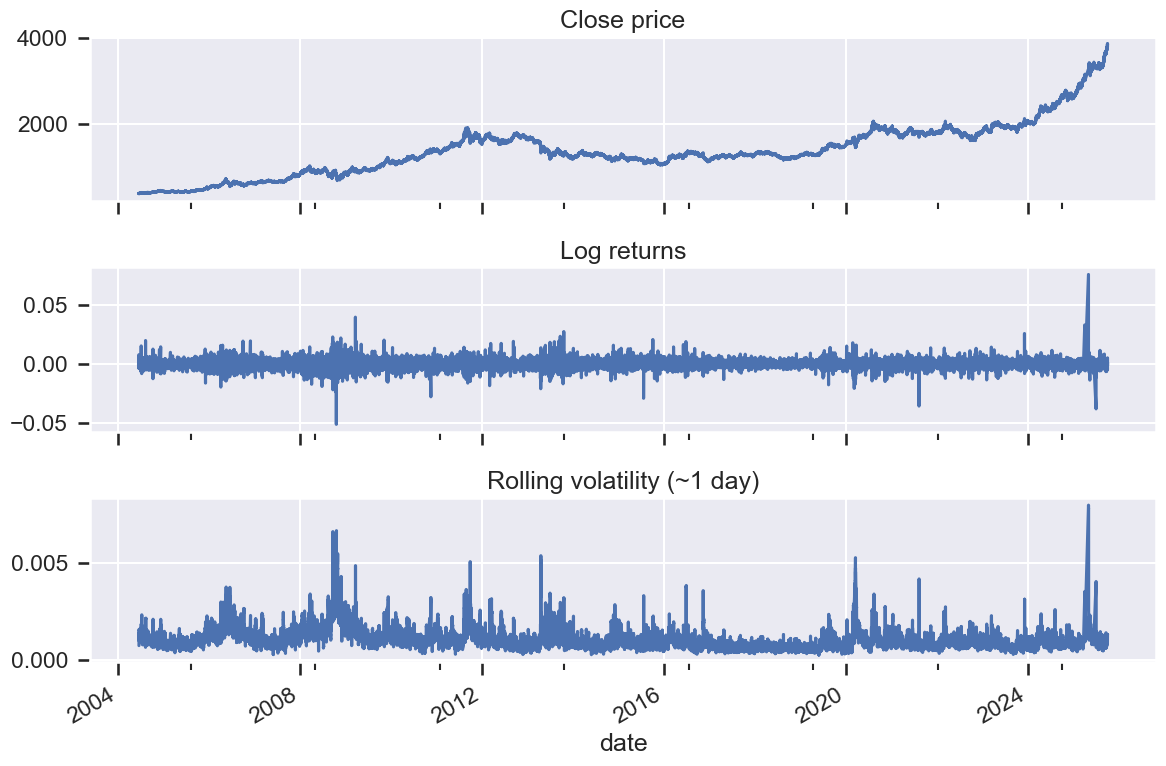

In [64]:
# Cell 6: Overview plots (tight_layout)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
df[price_col].plot(ax=axes[0], title='Close price')
df['log_ret'].plot(ax=axes[1], title='Log returns')
df['vol_rolling'].plot(ax=axes[2], title='Rolling volatility (~1 day)')
plt.tight_layout()
plt.show()


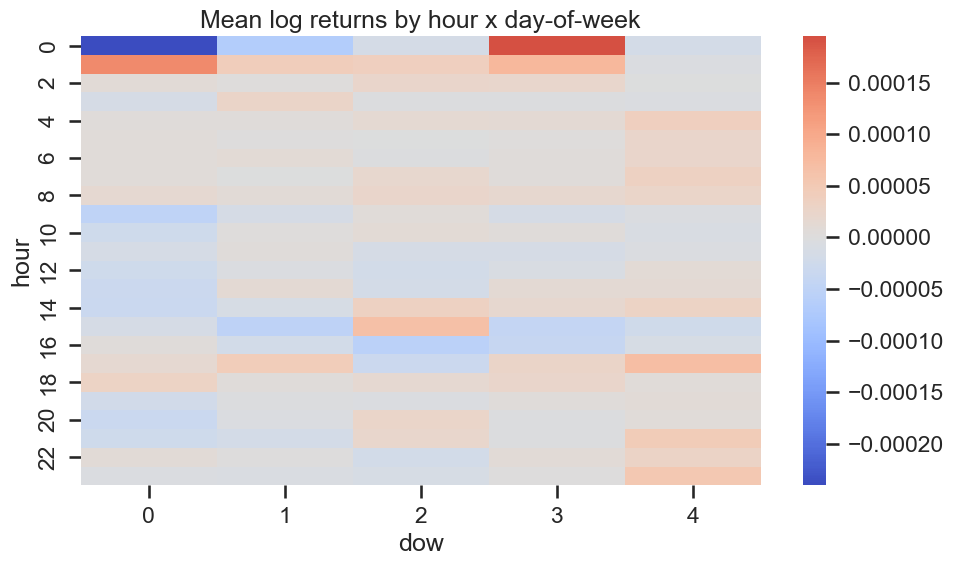

Pivot sample:
 dow          0         1         2         3         4
hour                                                  
0    -0.000240 -0.000067 -0.000017  0.000195 -0.000018
1     0.000137  0.000041  0.000037  0.000078 -0.000005
2     0.000009  0.000002  0.000023  0.000021 -0.000002
3    -0.000013  0.000028 -0.000003 -0.000003 -0.000005
4     0.000004  0.000006  0.000014  0.000012  0.000037


In [65]:
# Cell 7: Pivot table and heatmap (hour x day-of-week)
pv = df.pivot_table(index='hour', columns='dow', values='log_ret', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pv, cmap='coolwarm', center=0)
plt.title('Mean log returns by hour x day-of-week')
plt.tight_layout()
plt.show()

print("Pivot sample:\n", pv.round(6).head())


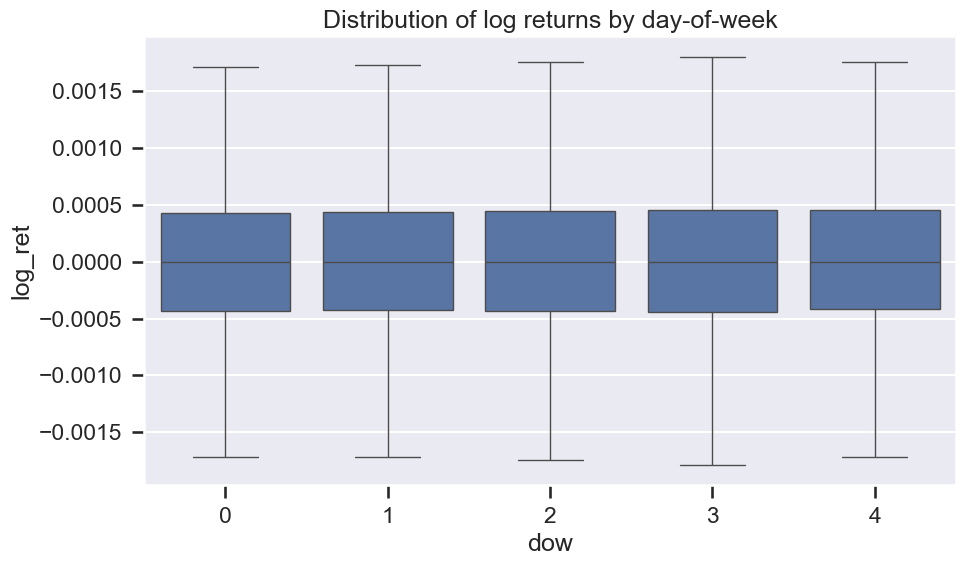

In [66]:
# Cell 8: Boxplot by day-of-week
plt.figure(figsize=(10, 6))
sns.boxplot(x='dow', y='log_ret', data=df, showfliers=False)
plt.title('Distribution of log returns by day-of-week')
plt.tight_layout()
plt.show()


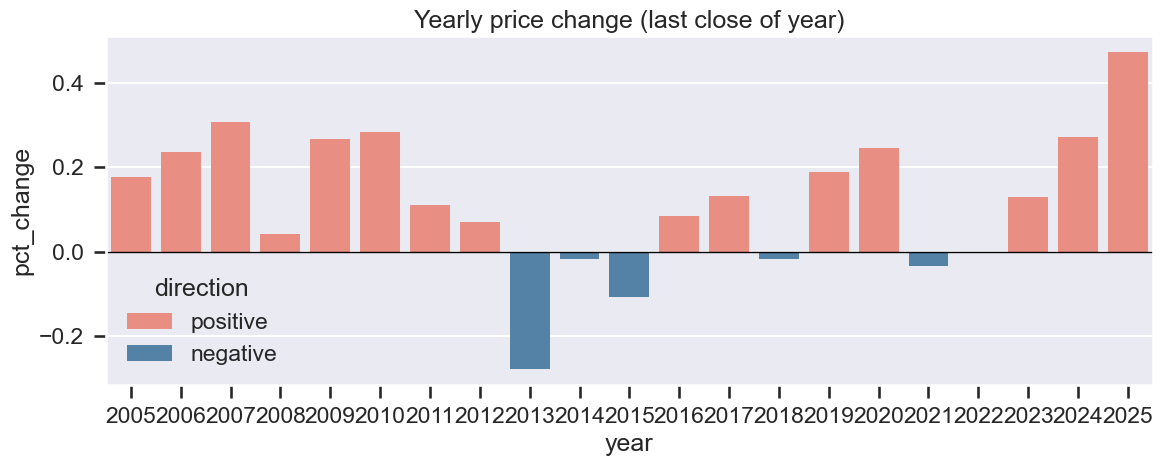

In [67]:
# Cell 9: Bar chart of yearly price changes
plt.figure(figsize=(12, 5))
sns.barplot(x='year', y='pct_change', data=yearly_df, hue='direction', dodge=False, palette=['salmon', 'steelblue'])
plt.axhline(0, color='black', linewidth=1)
plt.title('Yearly price change (last close of year)')
plt.tight_layout()
plt.show()


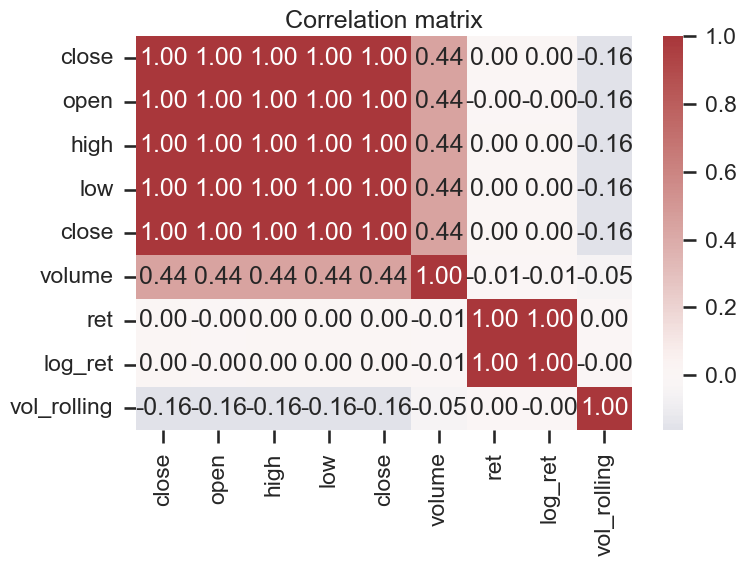


Correlation matrix:
              close   open   high    low  close  volume    ret  log_ret  \
close        1.000  1.000  1.000  1.000  1.000   0.439  0.002    0.002   
open         1.000  1.000  1.000  1.000  1.000   0.439 -0.000   -0.000   
high         1.000  1.000  1.000  1.000  1.000   0.439  0.001    0.001   
low          1.000  1.000  1.000  1.000  1.000   0.438  0.001    0.001   
close        1.000  1.000  1.000  1.000  1.000   0.439  0.002    0.002   
volume       0.439  0.439  0.439  0.438  0.439   1.000 -0.007   -0.007   
ret          0.002 -0.000  0.001  0.001  0.002  -0.007  1.000    1.000   
log_ret      0.002 -0.000  0.001  0.001  0.002  -0.007  1.000    1.000   
vol_rolling -0.162 -0.162 -0.161 -0.163 -0.162  -0.047  0.000   -0.000   

             vol_rolling  
close             -0.162  
open              -0.162  
high              -0.161  
low               -0.163  
close             -0.162  
volume            -0.047  
ret                0.000  
log_ret           -0.

In [68]:
# Cell 10: Correlation matrix (OHLCV + engineered features)
corr_cols = [c for c in [price_col, 'open','high','low','close','volume','ret','log_ret','vol_rolling'] if c in df.columns]
corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()
print("\nCorrelation matrix:\n", corr.round(3))



Top 25 drastic changes (timestamps and magnitudes):
                             log_ret
date                               
2025-05-01 01:00:00+00:00  0.075517
2008-10-16 15:30:00+00:00 -0.051010
2009-03-18 19:15:00+00:00  0.039458
2025-07-01 01:00:00+00:00 -0.037984
2021-08-09 01:45:00+00:00 -0.035594
2025-04-01 01:00:00+00:00  0.032926
2015-07-20 04:15:00+00:00 -0.029015
2010-11-15 01:00:00+00:00 -0.027740
2013-10-17 10:45:00+00:00  0.027297
2023-12-04 01:15:00+00:00  0.025652
2008-10-13 15:45:00+00:00 -0.023794
2013-09-18 21:00:00+00:00  0.023294
2008-09-17 15:30:00+00:00  0.022763
2008-11-21 16:30:00+00:00  0.021897
2008-09-18 21:30:00+00:00 -0.021858
2013-04-15 04:45:00+00:00 -0.020961
2020-03-06 17:15:00+00:00 -0.020654
2015-10-02 15:30:00+00:00  0.020580
2008-09-17 16:00:00+00:00  0.020378
2009-11-04 01:00:00+00:00  0.020100
2008-10-10 19:15:00+00:00 -0.019966
2004-08-06 15:00:00+00:00  0.019737
2006-04-03 01:00:00+00:00 -0.019556
2006-11-27 01:00:00+00:00  0.019400
2006-09-28

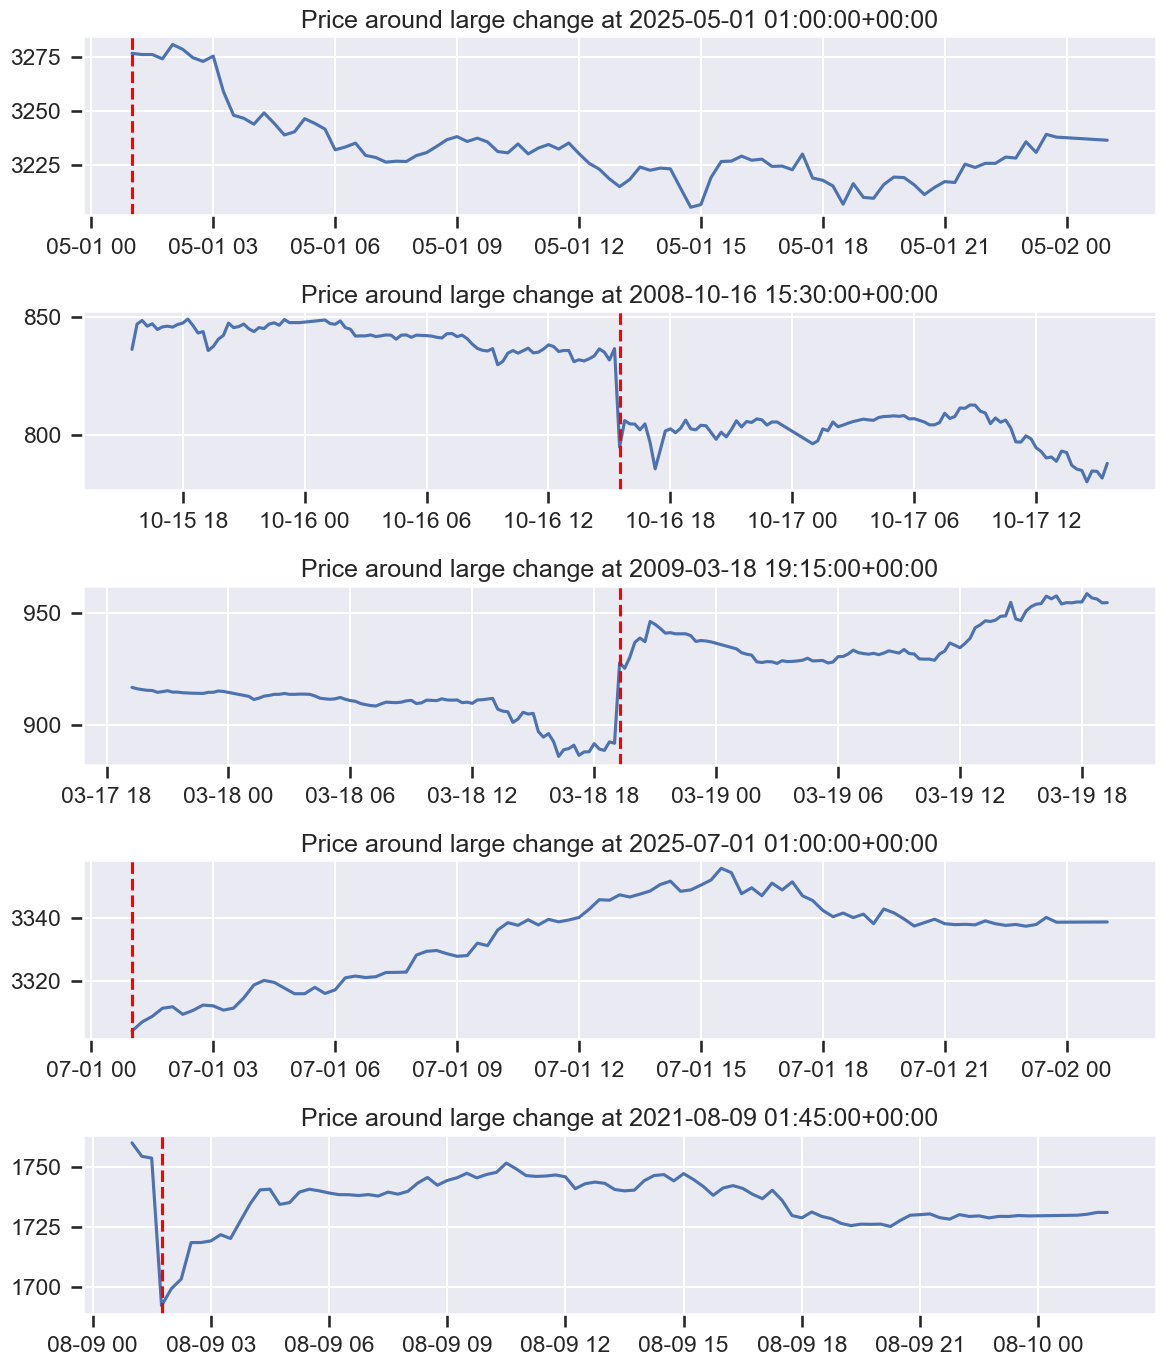

In [69]:
# Cell 11: Duration with drastic changes (top-N absolute returns)
N = 25
top_moves = df[['log_ret']].copy()
top_moves['abs_log_ret'] = top_moves['log_ret'].abs()
big_changes = top_moves.sort_values('abs_log_ret', ascending=False).head(N)
print(f"\nTop {N} drastic changes (timestamps and magnitudes):\n", big_changes[['log_ret']])

# Visualize a window around a few extremes
k = 5
timestamps = big_changes.index[:k]
WINDOW = 96  # ~1 day context
fig, axes = plt.subplots(k, 1, figsize=(12, 2*k+4), sharex=False)
for i, ts in enumerate(timestamps):
    w = df.loc[(df.index >= ts - pd.Timedelta(minutes=15*WINDOW)) & (df.index <= ts + pd.Timedelta(minutes=15*WINDOW)), price_col]
    axes[i].plot(w.index, w.values)
    axes[i].axvline(ts, color='red', linestyle='--')
    axes[i].set_title(f'Price around large change at {ts}')
plt.tight_layout()
plt.show()
